# Customized 3D imaging pipeline

With SPCSim user can create a customized 3D imaging pipeline with fine control over

* The simualted 3D scene properties
* Active illumination (laser) properties
* Intrinsic properties of the imaging sensor/camera
* Histogramming methods to compress the data captured by the imaging sensor
* Post-processing pipelines to obtain 3D scene distance from sensor measurements

In [97]:
from SPCSim.data_loaders.perpixel_loaders import PerPixelLoader
from SPCSim.data_loaders.transient_loaders import TransientGenerator
from SPCSim.utils.plot_utils import plot_transient, plot_ewh, plot_edh, plot_edh_traj
import matplotlib.pyplot as plt
from SPCSim.sensors.dtof import RawSPC, BaseEWHSPC, BaseEDHSPC, HEDHBaseClass, PEDHBaseClass, PEDHOptimized
from SPCSim.postproc.ewh_postproc import PostProcEWH
from SPCSim.postproc.edh_postproc import PostProcEDH
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import numpy as np

## Set the 3D scene properties

In [105]:
num_unique_distance_values = 10 # @param {type:"slider", min:1, max:1000, step:1}
min_distance_fraction = 0.25 # @param {type:"slider", min:0, max:0.9, step:0.05}
max_distance_fraction = 1 # @param {type:"slider", min:0.2, max:1, step:0.05}
signal_bkg_illumination_combinations = [[1,5]] # @param {type:"raw"}
num_independent_simulation_runs_per_combination = 11 # @param {type:"slider", min:1, max:1000, step:1}
device = 'cpu' # @param ["cpu", "cuda"]

## Set laser properties

In [10]:
laser_time_period_ns = 100.0 # @param {type:"number"}
num_time_bins = 1000 # @param {type:"integer"}
laser_FWHM_ns = 2 # @param {type:"number"}

## Select the sensor properties

In [98]:
sensor_id = "BaseEWHSPC" # @param ["RawSPC", "BaseEWHSPC", "BaseEDHSPC", "HEDHBaseClass", "PEDHBaseClass", "PEDHOptimized"]
num_laser_pulses = 3000 # @param {type:"number"}
num_histogram_bins = 8 # @param {type:"number"}
num_output_timestamps = 1000 # @param {type:"number"}

sensor_id_dict = {
    "RawSPC": RawSPC,
    "BaseEWHSPC": BaseEWHSPC,
    "BaseEDHSPC": BaseEDHSPC,
    "HEDHBaseClass": HEDHBaseClass,
    "PEDHBaseClass": PEDHBaseClass,
    "PEDHOptimized": PEDHOptimized
}

## Select experiment index to plot results

In [23]:
illumination_condition_index = 0 # @param {type:"integer"}
distance_value_index = 0 # @param {type:"integer"}
independent_run_index = 0 # @param {type:"integer"}

ROW = PixLdr.get_row(sbr_idx = illumination_condition_index,
                     dist_idx = distance_value_index)
COL = independent_run_index

100%|██████████| 3000/3000 [00:15<00:00, 192.65it/s]
<ipython-input-106-851e9c33ae7a>:135: UserWarning: Adding colorbar to a different Figure <Figure size 800x800 with 3 Axes> than <Figure size 800x400 with 1 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, cax=cax, orientation='vertical')
<ipython-input-106-851e9c33ae7a>:143: UserWarning: Adding colorbar to a different Figure <Figure size 800x800 with 4 Axes> than <Figure size 800x400 with 1 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, cax=cax, orientation='vertical')


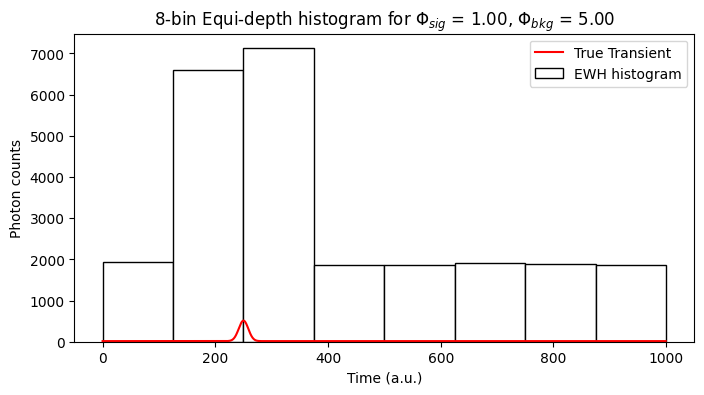

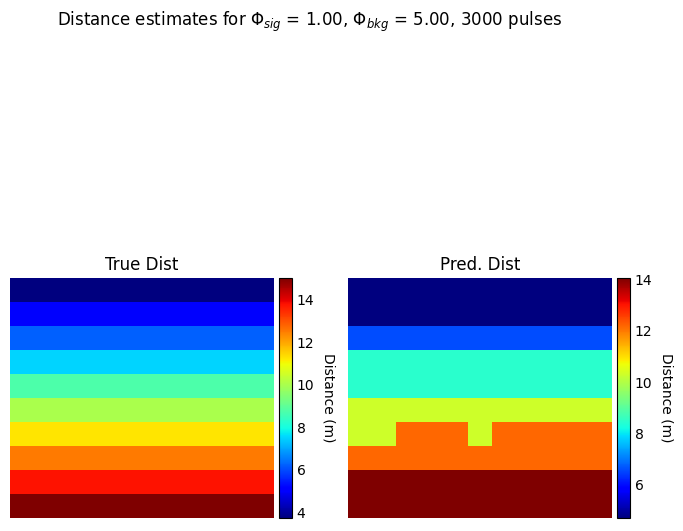

In [106]:
################################################################################
########## Setting the 3D scene parameters #####################################
################################################################################

# Simulating results for distance = 0.1*dmax
PixLdr = PerPixelLoader(
                        num_dists=num_unique_distance_values,
                        min_dist = min_distance_fraction,
                        max_dist = max_distance_fraction,
                        tmax = laser_time_period_ns,
                        sig_bkg_list = signal_bkg_illumination_combinations,
                        num_runs=num_independent_simulation_runs_per_combination,
                        device = device)

# Generate the per pixel data
data = PixLdr.get_data()


################################################################################
### Generating the transient for set scene conditions and laser parameters #####
################################################################################

# Creating transient generator with laser time period of 100ns, FWHM 1 and with
# laser time period divided into 1000 equal time-bins
tr_gen = TransientGenerator(Nr = PixLdr.Nr,
                            Nc = PixLdr.Nc,
                            N_tbins = num_time_bins,
                            tmax = PixLdr.tmax,
                            FWHM = laser_FWHM_ns)


# Using the get function to generate the transient
# for a given distance, albedo, intensity, and illumination condition
phi_bar = tr_gen.get_transient(data["gt_dist"],
                               data["albedo"],
                               data["albedo"],
                               data["alpha_sig"],
                               data["alpha_bkg"])

Nr, Nc, N_tbins = phi_bar.shape
device = PixLdr.device


################################################################################
########## Initialize object for selected sensor class #########################
################################################################################


SensorClass = sensor_id_dict[sensor_id]

if sensor_id == "RawSPC":
  spc1 = SensorClass(
      Nr,
      Nc,
      num_laser_pulses,
      device,
      num_time_bins,
      num_output_timestamps)
else:
  spc1 = SensorClass(
      Nr,
      Nc,
      num_laser_pulses,
      device,
      num_time_bins,
      num_histogram_bins)


################################################################################
########## Capture the dToF data for given exposure time #######################
################################################################################


captured_data = spc1.capture(phi_bar)

fig, ax1 = plt.subplots(1,1,figsize=(8,4))


################################################################################
########## Plot the data captured by the sensor data ###########################
##########     &    ############################################################
######## Reconstr 3D distance estimates using post-processing pipeline #########
################################################################################


if sensor_id == "RawSPC":

  raw_data = captured_data["time_stamps"]
  ewh_data = captured_data["ewh"]

  phi_bar1 = phi_bar[ROW, COL, :].cpu().numpy()
  ts = raw_data[ROW, COL, :].cpu().numpy().flatten()

  xaxis = torch.arange(0.5,1+N_tbins).to(torch.float)
  hist,_ = torch.histogram(raw_data[ROW,COL,:], xaxis)
  hist2 = ewh_data[ROW,COL,:]
  plot_transient(ax1, hist2.cpu().numpy(), plt_type = '-b', label="Captured EW histogram")
  plot_transient(ax1, hist.cpu().numpy(), plt_type = '--r', label="Timestamps histogram")
  plot_transient(ax1, phi_bar[ROW,COL,:].cpu().numpy()*spc1.N_output_ts/np.mean(np.sum(phi_bar.cpu().numpy(), axis=-1)), plt_type = '-g', label="True Transient")
  ax1.set_xlabel('Bins')
  ax1.set_ylabel('Frequency')
  ax1.set_title(r'Histogram of raw data for $\Phi_{sig}$ = %.2f, $\Phi_{bkg}$ = %.2f'%(data["alpha_sig"][ROW, COL], data["alpha_bkg"][ROW, COL]))
  ax1.legend()


elif sensor_id == "BaseEWHSPC":

  ewh_data = captured_data["ewh"].cpu().numpy()
  phi_bar = phi_bar.cpu().numpy()

  ewh_bins_axis = torch.linspace(0,N_tbins-N_tbins//num_histogram_bins,num_histogram_bins)

  plot_ewh(ax1, ewh_bins_axis, ewh_data[ROW, COL,:], label = "EWH histogram", color = 'w')
  plot_transient(ax1, phi_bar[ROW, COL,:]*spc1.N_pulses, plt_type = '-r', label="True Transient")
  ax1.set_xlabel("Time (a.u.)")
  ax1.set_ylabel("Photon counts")
  ax1.set_title(r'%d-bin Equi-depth histogram for $\Phi_{sig}$ = %.2f, $\Phi_{bkg}$ = %.2f'%(num_histogram_bins, data["alpha_sig"][ROW, COL], data["alpha_bkg"][ROW, COL]))
  plt.legend()

  postproc_ewh = PostProcEWH(
      Nr,
      Nc,
      num_time_bins,
      laser_time_period_ns,
      device
  )

  dist_idx, pred_dist = postproc_ewh.ewh2depth_t(captured_data["ewh"])
  fig2, ax2 = plt.subplots(1,2, figsize=(8,8))
  im = ax2[0].imshow(data["gt_dist"].cpu().numpy(), cmap = 'jet')
  ax2[0].axis('off')
  ax2[0].set_title("True Dist")
  divider = make_axes_locatable(ax2[0])
  cax = divider.append_axes('right', size='5%', pad=0.05)
  cbar = fig.colorbar(im, cax=cax, orientation='vertical')
  cbar.ax.tick_params(length=0)
  cbar.set_label('Distance (m)', rotation=270, labelpad=15)
  im = ax2[1].imshow(pred_dist, cmap = 'jet')
  ax2[1].axis('off')
  ax2[1].set_title("Pred. Dist")
  divider = make_axes_locatable(ax2[1])
  cax = divider.append_axes('right', size='5%', pad=0.05)
  cbar = fig.colorbar(im, cax=cax, orientation='vertical')
  cbar.ax.tick_params(length=0)
  cbar.set_label('Distance (m)', rotation=270, labelpad=15)

  fig2.suptitle(r'Distance estimates for $\Phi_{sig}$ = %.2f, $\Phi_{bkg}$ = %.2f, %d pulses'%(data["alpha_sig"][ROW,RUN], data["alpha_bkg"][ROW,RUN], spc1.N_pulses))
  fig2.savefig("DistanceOutput.png")


elif sensor_id == "BaseEDHSPC":
  oedh_data = captured_data["oedh"].cpu().numpy()
  gtedh_data = captured_data["gtedh"].cpu().numpy()
  ewh_data = captured_data["ewh"].cpu().numpy()
  phi_bar = phi_bar.cpu().numpy()

  ymax = ((np.sum(ewh_data[ROW,COL,:])/num_histogram_bins)).item()

  plot_edh(oedh_data[ROW,COL,:],
          ax1,
          ymax = ymax)

  plot_edh(gtedh_data[ROW,COL,:], ax1,
          tr = phi_bar[ROW, COL,:]*spc1.N_pulses,
          #  crop_window= tr_gen.FWHM*1.5*tr_gen.N_tbins*1.0/tr_gen.tmax, # uncoment this line to zoom into peak
          ymax = ymax, ls='--')
  ax1.set_title(r'Final %d-bin Oracle EDH boundaries for $\Phi_{sig}$ = %.2f, $\Phi_{bkg}$ = %.2f, %d pulses'%(num_histogram_bins,
                                                                                                               data["alpha_sig"][ROW,COL],
                                                                                                               data["alpha_bkg"][ROW,COL],
                                                                                                               spc1.N_pulses))


elif sensor_id in ["HEDHBaseClass","PEDHBaseclass", "PEDHOptimized"]:
  pedh_data = captured_data["edh"].cpu().numpy()
  gtedh_data = captured_data["gtedh"].cpu().numpy()
  ewh_data = captured_data["ewh"].cpu().numpy()
  edh_list = captured_data["traj"]
  phi_bar = phi_bar.cpu().numpy()
  edh_list = np.array(edh_list)

  ymax = ((np.sum(ewh_data[ROW,COL,:])/num_histogram_bins)).item()
  plot_edh(pedh_data[ROW,COL,:],
          ax1,
          ymax = ymax)
  plot_edh(gtedh_data[ROW,COL,:], ax1,
          tr = phi_bar[ROW, COL,:]*spc1.N_pulses,
          #  crop_window= tr_gen.FWHM*1.5*tr_gen.N_tbins*1.0/tr_gen.tmax,
          ymax = ymax, ls='--')
  ax1.set_title(r'Final EDH boundaries for $\Phi_{sig}$ = %.2f, $\Phi_{bkg}$ = %.2f, %d pulses'%(data["alpha_sig"][ROW,COL], data["alpha_bkg"][ROW,COL], spc1.N_pulses))
  # fig.savefig("Temp.png")

  fig_, ax_ = plt.subplots(1,1, figsize=(8,4))
  plot_edh_traj(ax_, edh_list, gtedh_data[ROW,COL,1:-1], ewh_data[ROW,COL,:])
  ax1.set_title(r'EDH CV trajectories for $\Phi_{sig}$ = %.2f, $\Phi_{bkg}$ = %.2f, %d pulses'%(data["alpha_sig"][ROW,COL], data["alpha_bkg"][ROW,COL], spc1.N_pulses))
  plt.plot()

else:
  print("Incorrect Sensor choice")